<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Erin/30min_widernn_Grid_Test_Knock_In_Call_3stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

In [34]:
import pandas as pd

In [35]:
nstock = 3
model_save_name = f'jax_knock_in_{str(nstock)}stocks_2.pth'

# Dataset generation

In [36]:
# from google.colab import drive
# drive.mount('/content/drive')

In [37]:
# import cupy
# import jax
# import jax.numpy as jnp
# from jax import random
# from jax import jit
# import numpy as np
# import pandas as pd
# from torch.utils.dlpack import from_dlpack

# def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
#     stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
#     stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
#                             jax.ops.index[0],         # initialization of stock prices
#                             initial_stocks)
#     noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
#     sigma = jnp.diag(cov) ** 0.5
#     dt = T / numsteps
#     def time_step(t, val):
#         dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
#         val = jax.ops.index_update(val,
#                             jax.ops.index[t],
#                             val[t-1] * dx)
#         return val
#     return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

# def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
#     out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
#     knock_in_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
#     r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_in_index]/(knock_in_index+1)

#     return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
#                     (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_in_index] - K) *   # (S[knock-in]-K)
#                     jnp.exp(- r_mean_array * (T * (knock_in_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

# goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

# #################################################################### Adjust all parameters here (not inside class)
# numstocks = 3
# numsteps = 50
# numpaths = 2000000

# rng = jax.random.PRNGKey(np.random.randint(10000))
# rng, key = jax.random.split(rng)
# keys = jax.random.split(key, numpaths)

# S1_range = jnp.linspace(0.75, 1.25, 6)[2:4]
# S2_range = jnp.linspace(0.75, 1.25, 6)
# S3_range = jnp.linspace(0.75, 1.25, 6)
# K_range = jnp.linspace(0.75, 1.25, 5)
# B_range = jnp.linspace(1.1, 1.6, 6)
# sigma_range = jnp.linspace(0.15, 0.45, 3)
# r_range = jnp.linspace(0.01, 0.04, 3)
# T = 1.0

# fast_simple = jax.jit(Brownian_motion, static_argnums=2)
# batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
# ####################################################################

# call = []
# count = 0

# for S1 in S1_range:
#   for S2 in S2_range:
#     for S3 in S3_range:
#       for K in K_range:
#         for B in B_range:
#           for r in r_range:
#             for sigma in sigma_range:

#               initial_stocks = jnp.array([S1, S2, S3]) # must be float
#               r_tmp = jnp.array([r]*numsteps)
#               drift = jnp.array([r]*numstocks)
#               cov = jnp.identity(numstocks)*sigma*sigma

#               Knock_In_Call_price = optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)
#               Deltas = goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)
#               call.append([T, K, B, S1, sigma, r, r,
#                           T, K, B, S2, sigma, r, r,
#                           T, K, B, S3, sigma, r, r, Knock_In_Call_price] + list(Deltas)) #T, K, B, S, sigma, mu, r, price, delta
              
#               count += 1
#               print(count)


# Thedataset = pd.DataFrame(call)

# #save to csv
# Thedataset.to_csv(f'/content/drive/MyDrive/AFP/Save_Models/Knock_In_Call_{str(nstock)}stocks_Datset_part{part}.csv', index=False, header=False)

# Access to the Dataset

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# read csv
Thedataset = pd.read_csv(f'/content/drive/MyDrive/AFP/Save_Models/Knock_In_Call_{str(nstock)}stocks_Datset.csv', header=None)

# Construct Neural Net

In [40]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)

Thedataset_X = Thedataset.iloc[:,:7*nstock]
Thedataset_Y = Thedataset.iloc[:,7*nstock:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# print
# ds = OptionDataSet(max_len = 1)
# for i in ds:
#     print(i[0])
#     print(i[0].shape)
#     print(i[1])
#     print(i[1].shape)

In [41]:
# %%writefile model.py
# import torch.nn as nn
# import torch.nn.functional as F
# import torch
# import numpy as np

# class Net(nn.Module):

#     def __init__(self, hidden=1024, nstock = 1):
#         self.nstock = nstock
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(7*self.nstock, 64) # remember to change this!
#         self.fc2 = nn.Linear(64, 128)
#         self.fc3 = nn.Linear(128, 256)
#         self.fc4 = nn.Linear(256, 128)
#         self.fc5 = nn.Linear(128, 64)
#         self.fc6 = nn.Linear(64, nstock + 1) # outputs: prices, delta
#         self.register_buffer('norm',
#                              torch.tensor([1.0, 0.5, 0.5, 0.5, 0.3, 0.03, 0.03] * self.nstock)) # don't use numpy here - will give error later
#                                                                                # T, K, B, S, sigma, mu, r

#     def forward(self, x):
#         # normalize the parameter to range [0-1] 
#         x = (x - torch.tensor([0.0, 0.75, 1.1, 0.75, 0.15, 0.01, 0.01] * self.nstock).cuda()) / self.norm
#         x = F.elu(self.fc1(x))
#         x = F.elu(self.fc2(x))
#         x = F.elu(self.fc3(x))
#         x = F.elu(self.fc4(x))
#         x = F.elu(self.fc5(x))
#         return self.fc6(x)

In [42]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024, nstock = 1):
        self.nstock = nstock
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7*self.nstock, 128) # remember to change this!
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, nstock + 1) # outputs: prices, delta
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.5, 0.3, 0.03, 0.03] * self.nstock)) # don't use numpy here - will give error later
                                                                               # T, K, B, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 1.1, 0.75, 0.15, 0.01, 0.01] * self.nstock).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Overwriting model.py


# Train Neural Net

In [43]:
!pip install pytorch-ignite

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net(nstock = nstock).cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    # def compute_deltas(x):
    #   inputs = x.float()
    #   inputs.requires_grad = True
    #   first_order_gradient = grad(model(inputs), inputs, create_graph=False)
    #   return first_order_gradient[0][[3]]  # Now index 3 is stock price, not 2

    # deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    # y_pred = torch.cat((y_pred, deltas), 1)
    # # print(y_pred)
    # # print(y_pred.shape)

    loss_weight = torch.tensor([1] * (nstock+1)).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 1000)

# model_save_name = f'jax_knock_out_{str(nstock)}stocks_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.006063429861589444 average time 0.013162081150085214 iter num 20
loss 0.003940818779167358 average time 0.012809775500033992 iter num 40
loss 0.002778303297653202 average time 0.012677768750025582 iter num 60
loss 0.0025031048808781715 average time 0.012603179250027097 iter num 80
loss 0.0024654775426624425 average time 0.012576561880027839 iter num 100
loss 0.002147944316677487 average time 0.012372994500060486 iter num 20
loss 0.002052406872096366 average time 0.012360781499990026 iter num 40
loss 0.0020187612004742114 average time 0.012372299533346147 iter num 60
loss 0.0020049564962043897 average time 0.012364559787494045 iter num 80
loss 0.002002031265064599 average time 0.012376603220000107 iter num 100
loss 0.0019460016156961283 average time 0.012447936049989039 iter num 20
loss 0.0018963448875134407 average time 0.012417548824976166 iter num 40
loss 0.0018627456365305235 average time 0.012407333399990724 iter num 60
loss 0.0018469616024526648 average time 0.0123967745250

In [46]:
# 20min

**Save Model**

In [47]:
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
import torch
# model_save_name = f'jax_knock_out_{str(nstock)}stocks_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [49]:
# from google.colab import drive
# drive.mount('/content/drive')

In [50]:
import torch
# model_save_name = f'jax_knock_out_{str(nstock)}stocks_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [51]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net(nstock = nstock).cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=21, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=4, bias=True)
)


**Continue to train model**

In [52]:
# from google.colab import drive
# drive.mount('/content/drive')

In [53]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net(nstock = nstock).cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3, eps=1e-4, amsgrad=True) # try using higher epsilon and amsgrad
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x.float())

    loss_weight = torch.tensor([1] * (nstock+1)).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 500)

model_save_name = model_save_name[:-4] + '_continue.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 1.679709930173172e-07 average time 0.012372391449980568 iter num 20
loss 1.6796350124525863e-07 average time 0.012423329975013076 iter num 40
loss 1.679599127542714e-07 average time 0.01244852486668909 iter num 60
loss 1.6795870816045816e-07 average time 0.012468728787541749 iter num 80
loss 1.6795840904892095e-07 average time 0.012450014030036982 iter num 100
loss 1.6795113971097237e-07 average time 0.012441322549966572 iter num 20
loss 1.6794508741066596e-07 average time 0.012421010225011742 iter num 40
loss 1.6794131942754578e-07 average time 0.012446854466664567 iter num 60
loss 1.6794026205936193e-07 average time 0.012468643549993885 iter num 80
loss 1.6794010144468738e-07 average time 0.01247382571998969 iter num 100
loss 1.6793286371714468e-07 average time 0.012442043649980406 iter num 20
loss 1.6792697981398833e-07 average time 0.012486721250024858 iter num 40
loss 1.6792323470185279e-07 average time 0.012506293716675524 iter num 60
loss 1.679220911244112e-07 average time 

In [54]:
# 10min

#Results

In [55]:
# Knock in call
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    knock_in_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
    r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_in_index]/(knock_in_index+1)

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_in_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_in_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)

numstocks = 3
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

K = 1.0
T = 1.0
r = 0.02
sigma = 0.25
B = 1.15
initial_stocks = jnp.array([1.]*numstocks) # must be float
r_tmp = jnp.array([r]*numsteps)
drift = jnp.array([r]*numstocks)
cov = jnp.identity(numstocks)*sigma*sigma

fast_simple = jax.jit(Brownian_motion, static_argnums=2)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
# print(optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)) # here numsteps different from T

# delta
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
# print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)) # here numsteps different from T

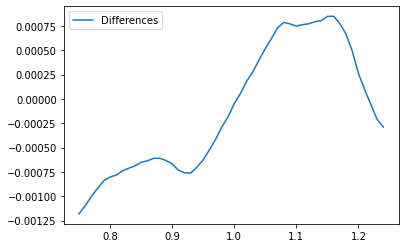

In [56]:
import matplotlib.pyplot as plt
import numpy as np

B = 1.15
s1 = 1.
s3 = 1.15

def compute_price(S):
    inputs = torch.tensor([[1, 1, B, s1, 0.25, 0.02, 0.02] + [1, 1, B, S, 0.25, 0.02, 0.02] + [1, 1, B, s3, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][0]

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
correct_call_prices = []
for p in prices:
    initial_stocks = jnp.array([s1, p, s3]) # must be float
    model_call_prices.append(compute_price(p).item())
    correct_call_prices.append(optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, correct_call_prices, label = "JAX_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(correct_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

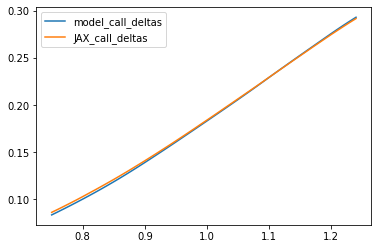

In [57]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.15

def compute_delta(S):
    inputs = torch.tensor([[1, 1, B, s1, 0.25, 0.02, 0.02] + [1, 1, B, S, 0.25, 0.02, 0.02] + [1, 1, B, s3, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][2]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([s1, p, s3]) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)[1])
plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

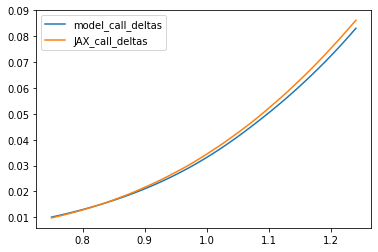

In [58]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.35

def compute_delta(S):
    inputs = torch.tensor([[1, 1, B, s1, 0.25, 0.02, 0.02] + [1, 1, B, S, 0.25, 0.02, 0.02] + [1, 1, B, s3, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][2]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([s1, p, s3]) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)[1])
plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

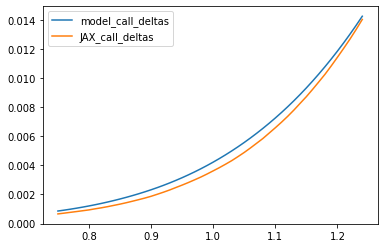

In [59]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.55

def compute_delta(S):
    inputs = torch.tensor([[1, 1, B, s1, 0.25, 0.02, 0.02] + [1, 1, B, S, 0.25, 0.02, 0.02] + [1, 1, B, s3, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][2]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([s1, p, s3]) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)[1])
plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

# Comparison on speed

In [60]:
%timeit goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, 0.75, B, T, numpaths)
%timeit compute_delta(1).item()

10 loops, best of 5: 889 ms per loop
The slowest run took 1834.28 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 402 µs per loop
